In [27]:
import tensorflow as tf
import time
import os

from model import Model
from configs import config
from model_only import fcn

#from data_util import data_loader, load_data

In [2]:
print(tf.__version__)

1.13.0-dev20190223


In [3]:
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
print_tensors_in_checkpoint_file('Models_Given/model-50000', all_tensors=False, all_tensor_names=False, tensor_name='')

beta1_power (DT_FLOAT) []
beta2_power (DT_FLOAT) []
fcn/conv1-1/bias (DT_FLOAT) [96]
fcn/conv1-1/bias/Adam (DT_FLOAT) [96]
fcn/conv1-1/bias/Adam_1 (DT_FLOAT) [96]
fcn/conv1-1/kernel (DT_FLOAT) [3,3,3,96]
fcn/conv1-1/kernel/Adam (DT_FLOAT) [3,3,3,96]
fcn/conv1-1/kernel/Adam_1 (DT_FLOAT) [3,3,3,96]
fcn/conv1-2/bias (DT_FLOAT) [96]
fcn/conv1-2/bias/Adam (DT_FLOAT) [96]
fcn/conv1-2/bias/Adam_1 (DT_FLOAT) [96]
fcn/conv1-2/kernel (DT_FLOAT) [3,3,96,96]
fcn/conv1-2/kernel/Adam (DT_FLOAT) [3,3,96,96]
fcn/conv1-2/kernel/Adam_1 (DT_FLOAT) [3,3,96,96]
fcn/conv2-1/bias (DT_FLOAT) [192]
fcn/conv2-1/bias/Adam (DT_FLOAT) [192]
fcn/conv2-1/bias/Adam_1 (DT_FLOAT) [192]
fcn/conv2-1/kernel (DT_FLOAT) [3,3,96,192]
fcn/conv2-1/kernel/Adam (DT_FLOAT) [3,3,96,192]
fcn/conv2-1/kernel/Adam_1 (DT_FLOAT) [3,3,96,192]
fcn/conv2-2/bias (DT_FLOAT) [192]
fcn/conv2-2/bias/Adam (DT_FLOAT) [192]
fcn/conv2-2/bias/Adam_1 (DT_FLOAT) [192]
fcn/conv2-2/kernel (DT_FLOAT) [3,3,192,192]
fcn/conv2-2/kernel/Adam (DT_FLOAT) [3,3,

In [5]:
tf.lite

<module 'tensorflow._api.v1.lite' from 'C:\\Users\\vikra\\AppData\\Local\\conda\\conda\\envs\\tf\\lib\\site-packages\\tensorflow\\_api\\v1\\lite\\__init__.py'>

In [18]:
converter = tf.lite.TFLiteConverter.from_saved_model("Models_Given/")
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

OSError: SavedModel file does not exist at: Models_Given//{saved_model.pbtxt|saved_model.pb}

In [30]:
# reset default graph
tf.reset_default_graph()
images = tf.placeholder(name='images', dtype=tf.float32, shape=[None, 32, 32, 3])
fine_labels = tf.placeholder(name='fine_labels', dtype=tf.int32, shape=[None])
logits = fcn(images, is_training=True)
# probs = tf.nn.softmax(logits)
# pred = tf.cast(tf.argmax(logits, axis=1), tf.int32)
loss = tf.losses.softmax_cross_entropy(tf.one_hot(fine_labels, 10), logits)
# training setups
saver = tf.train.Saver(max_to_keep=100)


with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    saver.restore(session, "Models_Given/model-50000")

W0223 18:46:26.555997  8176 deprecation.py:323] From C:\Users\vikra\AppData\Local\conda\conda\envs\tf\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [31]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  converter = tf.lite.TFLiteConverter.from_session(sess, [images], [logits])
  tflite_model = converter.convert()
  open("converted_model.tflite", "wb").write(tflite_model)

W0223 18:47:52.070073  8176 deprecation.py:323] From C:\Users\vikra\AppData\Local\conda\conda\envs\tf\lib\site-packages\tensorflow\lite\python\lite.py:881: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
W0223 18:47:52.071068  8176 deprecation.py:323] From C:\Users\vikra\AppData\Local\conda\conda\envs\tf\lib\site-packages\tensorflow\python\framework\graph_util_impl.py:246: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph


In [39]:
from utils import *

In [63]:
#Load Dataset
X_train0, y_train = prepare_dataset(data_dir, 'train')
X_test0, y_test = prepare_dataset(data_dir, 'test')
t = int(time.time())

Loading numpy
Loading numpy


In [46]:
X_train =(X_train0/255).astype(np.float32)
X_test = (X_test0/255).astype(np.float32)

In [47]:
X_train.dtype

dtype('float32')

In [55]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="converted_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


[[ 1.7515241e+09  5.7777542e+08 -2.3856262e+08 -8.5761768e+07
   1.6284041e+09  2.3183670e+09  7.7388787e+08 -5.0431600e+07
   1.2323154e+09 -3.8430118e+08]]


In [81]:
# Test model on test data.
#input_shape = input_details[0]['shape']
acc = 0
for i,img in enumerate(X_test):
    print(i)
    input_data = np.expand_dims(img, axis=0)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    #print(output_data)
    y_pred = np.argmax(output_data, axis=1)
    if (y_test[i] == y_pred[0]):
        acc +=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102


3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747


5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428


6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
7118
7119
7120
7121
7122
7123
7124


8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744
8745
8746
8747
8748
8749
8750
8751
8752
8753
8754
8755
8756
8757
8758
8759
8760
8761
8762
8763
8764
8765
8766
8767
8768
8769
8770
8771
8772
8773
8774
8775
8776
8777
8778
8779
8780
8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800
8801
8802
8803
8804
8805
8806
8807
8808
8809
8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823
8824
8825
8826
8827
8828
8829
8830
8831
8832
8833
8834
8835
8836
8837
8838
8839
8840
8841
8842
8843
8844
8845
8846
8847
8848
8849
8850
8851
8852
8853
8854
8855
8856
8857
8858
8859
8860
8861
8862
8863
8864
8865
8866
8867
8868
8869
8870
8871
8872
8873
8874
8875
8876
8877
8878
8879
8880
8881
8882
8883
8884
8885


In [64]:
y_pred = np.argmax(output_data, axis=1)
y_test[0] == y_pred

array([False])

In [82]:
acc

999

In [5]:
%matplotlib inline
from utils import *

Using TensorFlow backend.


In [6]:
#Load Dataset
X_train0, y_train = prepare_dataset(data_dir, 'train')
X_test0, y_test = prepare_dataset(data_dir, 'test')
t = int(time.time())

Loading numpy
Loading numpy


In [7]:
#Normalizing
mean = np.mean(X_train0,axis=(0,1,2,3))
std = np.std(X_train0,axis=(0,1,2,3))
np.save('mean',mean)
np.save('std',std)
X_train = z_normalization(X_train0, mean, std)
X_test = z_normalization(X_test0, mean, std)

In [8]:
#Labels to binary
y_train_binary = keras.utils.to_categorical(y_train,num_classes)
y_test_binary = keras.utils.to_categorical(y_test,num_classes)

In [5]:
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Reshape, Activation

In [6]:
#CNN Model
model = Sequential()
model.add(Conv2D(96, kernel_size=(3, 3),
           activation='relu',
           input_shape=X_train.shape[1:],
           padding='same', name='Conv_1'))
model.add(BatchNormalization(name='Bn_1')) 
model.add(Conv2D(96, kernel_size=(3, 3), activation='relu',padding='same',  name='Conv_2'))
model.add(BatchNormalization(name='Bn_2')) 
model.add(MaxPooling2D(pool_size=(3, 3), strides = 2, padding = 'same', name='Max_pool_1'))  
#model.add(Dropout(p, name='Drop_1'))
model.add(Conv2D(192, kernel_size=(3, 3), activation='relu',padding='same',  name='Conv_3'))
model.add(BatchNormalization(name='Bn_3')) 
model.add(Conv2D(192, kernel_size=(3, 3), activation='relu',padding='same',  name='Conv_4'))
model.add(BatchNormalization(name='Bn_4')) 
model.add(MaxPooling2D(pool_size=(3, 3), strides = 2, padding = 'same',name='Max_pool_2'))  
#model.add(Dropout(p, name='Drop_2'))
model.add(Conv2D(192, kernel_size=(3, 3), activation='relu',padding='valid',  name='Conv_5'))
model.add(BatchNormalization(name='Bn_5')) 
model.add(Conv2D(192, kernel_size=(1, 1), activation='relu',padding='same',  name='Conv_6'))
model.add(BatchNormalization(name='Bn_6')) 
model.add(Conv2D(10, kernel_size=(1, 1), activation='relu',padding='same',  name='Conv_7'))
#model.add(MaxPooling2D(pool_size=(2, 2), name='Max_pool_3'))  
#model.add(Dropout(p, name='Drop_3'))
#model.add(Flatten(name = 'Flatten_1'))
#model.add(Dense(32, activation='relu'))
model.add(BatchNormalization(name='Bn_7')) 
#model.add(Dropout(p, name='Drop_4'))
model.add(AveragePooling2D(pool_size=(6, 6), strides=1, name='avg_pool'))  
#model.add(Reshape((-1,num_classes), name='Reshape_1'))
model.add(Flatten(name = 'Flatten_1'))
model.add(Activation('softmax', name = 'output'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 32, 32, 96)        2688      
_________________________________________________________________
Bn_1 (BatchNormalization)    (None, 32, 32, 96)        384       
_________________________________________________________________
Conv_2 (Conv2D)              (None, 32, 32, 96)        83040     
_________________________________________________________________
Bn_2 (BatchNormalization)    (None, 32, 32, 96)        384       
_________________________________________________________________
Max_pool_1 (MaxPooling2D)    (None, 16, 16, 96)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 16, 16, 192)       166080    
_________________________________________________________________
Bn_3 (BatchNormalization)    (None, 16, 16, 192)       768       
__________

In [8]:
#Training Model
model, H = train_CNN_model(model, X_train, y_train_binary, X_test, y_test_binary, model_dir, t, batch_size=256, epochs=100)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 34s 684us/step - loss: 0.9146 - acc: 0.7425 - val_loss: 0.9620 - val_acc: 0.7032

Epoch 00001: val_acc improved from -inf to 0.70320, saving model to Models\best_Cifar10_CNN_1551058158
Epoch 2/100
50000/50000 [==============================] - 33s 669us/step - loss: 0.6891 - acc: 0.8156 - val_loss: 0.7497 - val_acc: 0.7856

Epoch 00002: val_acc improved from 0.70320 to 0.78560, saving model to Models\best_Cifar10_CNN_1551058158
Epoch 3/100
50000/50000 [==============================] - 33s 669us/step - loss: 0.5427 - acc: 0.8611 - val_loss: 0.6843 - val_acc: 0.7989

Epoch 00003: val_acc improved from 0.78560 to 0.79890, saving model to Models\best_Cifar10_CNN_1551058158
Epoch 4/100
50000/50000 [==============================] - 33s 669us/step - loss: 0.4300 - acc: 0.8934 - val_loss: 0.6442 - val_acc: 0.8092

Epoch 00004: val_acc improved from 0.79890 to 0.80920, saving model to 

Epoch 39/100
50000/50000 [==============================] - 33s 668us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.3928 - val_acc: 0.8840

Epoch 00039: val_acc did not improve from 0.88650
Epoch 40/100
50000/50000 [==============================] - 33s 667us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.3988 - val_acc: 0.8866

Epoch 00040: val_acc improved from 0.88650 to 0.88660, saving model to Models\best_Cifar10_CNN_1551058158
Epoch 41/100
50000/50000 [==============================] - 33s 667us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.3964 - val_acc: 0.8875

Epoch 00041: val_acc improved from 0.88660 to 0.88750, saving model to Models\best_Cifar10_CNN_1551058158
Epoch 42/100
50000/50000 [==============================] - 33s 667us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.3985 - val_acc: 0.8882

Epoch 00042: val_acc improved from 0.88750 to 0.88820, saving model to Models\best_Cifar10_CNN_1551058158
Epoch 43/100
50000/50000 [==============================] - 33s 


Epoch 00080: val_acc did not improve from 0.88820
Epoch 81/100
50000/50000 [==============================] - 33s 665us/step - loss: 0.0055 - acc: 0.9996 - val_loss: 0.4344 - val_acc: 0.8786

Epoch 00081: val_acc did not improve from 0.88820
Epoch 82/100
50000/50000 [==============================] - 33s 666us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.4324 - val_acc: 0.8797

Epoch 00082: val_acc did not improve from 0.88820
Epoch 83/100
50000/50000 [==============================] - 33s 665us/step - loss: 0.0020 - acc: 0.9999 - val_loss: 0.4391 - val_acc: 0.8809

Epoch 00083: val_acc did not improve from 0.88820
Epoch 84/100
50000/50000 [==============================] - 33s 667us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.4266 - val_acc: 0.8864

Epoch 00084: val_acc did not improve from 0.88820
Epoch 85/100
50000/50000 [==============================] - 33s 664us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.4415 - val_acc: 0.8855

Epoch 00085: val_acc did not improve fr

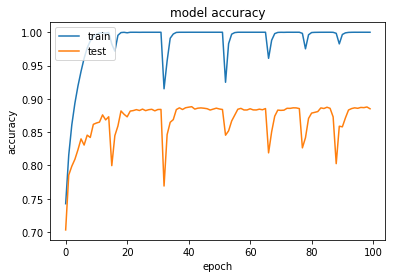

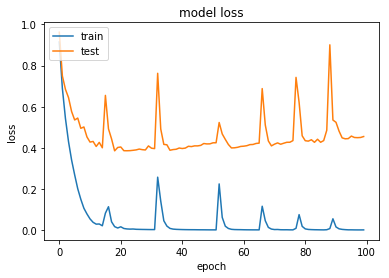

In [9]:
# summarize history for accuracy and loss
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
model.save('keras_model.h5')

In [1]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model_file("keras_model.h5")
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

W0224 19:24:48.877000 16576 deprecation.py:506] From C:\Users\vikra\AppData\Local\conda\conda\envs\tf\lib\site-packages\tensorflow\python\keras\engine\base_layer_utils.py:127: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0224 19:24:50.022027 16576 deprecation.py:323] From C:\Users\vikra\AppData\Local\conda\conda\envs\tf\lib\site-packages\tensorflow\lite\python\lite.py:881: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
W0224 19:24:50.023024 16576 deprecation.py:323] From C:\Users\vikra\AppData\Local\conda\conda\envs\tf\lib\site-packages\tensorflow\python\framework\graph_util_impl.py:246: extract_sub_graph (from tens

3833504

In [33]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="converted_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
#input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
input_data = np.array(np.expand_dims(X_test[0], axis=0), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[2.2388062e-07 1.6940398e-07 3.0950258e-07 9.9999809e-01 1.2823884e-07
  2.5402554e-07 1.1052264e-07 1.5745211e-07 4.5851183e-07 1.2222046e-07]]


In [35]:
# Test model on test data.
#input_shape = input_details[0]['shape']
acc = 0
y_pred = []
for i,img in enumerate(X_test):
    print(i)
    input_data = np.array(np.expand_dims(img, axis=0), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    #print(output_data)
    y_pred.append(np.argmax(output_data, axis=1))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080


3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736


5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375


6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021


8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676


In [44]:
np.asarray(y_pred)

array([3], dtype=int64)

In [45]:
accuracy = accuracy_score(y_true, y_pred)

In [47]:
accuracy

0.8851

In [49]:
output_details

[{'name': 'output/Softmax',
  'index': 55,
  'shape': array([ 1, 10]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

In [53]:
converter = tf.lite.TFLiteConverter.from_keras_model_file("keras_model.h5")
tf.logging.set_verbosity(tf.logging.INFO)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open("quantized_model.tflite", "wb").write(tflite_quant_model)

I0224 20:04:10.254301 16576 graph_util_impl.py:269] Froze 42 variables.
I0224 20:04:10.292170 16576 graph_util_impl.py:302] Converted 42 variables to const ops.


972168

In [54]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="quantized_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
#input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
input_data = np.array(np.expand_dims(X_test[0], axis=0), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[1.61503948e-07 1.09672435e-07 2.25162452e-07 9.99998569e-01
  7.98818149e-08 1.75289642e-07 7.61152350e-08 1.12514407e-07
  3.45018208e-07 7.66459607e-08]]


In [55]:
# Test model on test data.
#input_shape = input_details[0]['shape']
acc = 0
y_pred = []
for i,img in enumerate(X_test):
    print(i)
    input_data = np.array(np.expand_dims(img, axis=0), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    #print(output_data)
    y_pred.append(np.argmax(output_data, axis=1))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110


3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764


5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494


7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182
7183
7184
7185
7186
7187
7188
7189
7190
7191
7192
7193
7194
7195
7196
7197
7198
7199
7200
7201
7202
7203
7204
7205
7206
7207
7208
7209
7210
7211
7212
7213
7214
7215


8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744
8745
8746
8747
8748
8749
8750
8751
8752
8753
8754
8755
8756
8757
8758
8759
8760
8761
8762
8763
8764
8765
8766
8767
8768
8769
8770
8771
8772
8773
8774
8775
8776
8777
8778
8779
8780
8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800
8801
8802
8803
8804
8805
8806
8807
8808
8809
8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823
8824
8825
8826
8827
8828
8829
8830
8831
8832
8833
8834
8835
8836
8837
8838
8839
8840
8841
8842
8843
8844
8845
8846
8847
8848
8849
8850
8851
8852
8853
8854
8855
8856
8857
8858
8859
8860
8861
8862
8863
8864
8865
8866
8867
8868
8869
8870
8871
8872
8873
8874
8875
8876
8877
8878
8879
8880
8881


In [56]:
accuracy = accuracy_score(y_true, y_pred)

In [57]:
accuracy

0.8843